In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
#     tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(
    0
)
import numpy as np
import random
import pandas as pd
# df = pd.read_pickle('seeds_iterated_onethird.pkl')
# print(df[df[0] >= 0.05].sort_values(0,ascending = False))
# df = df.drop(df[df[0] == df[0].max()].index[0])
# SEED = int(df[df[0] == df[0].max()].index[0])
SEED = 3
print(SEED)
# SEED = 3
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

2023-09-13 13:28:23.250040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3


In [2]:
import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import shapiro 
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [3]:
df1 = gl.coregister_data('1')
df2 = gl.coregister_data('2')
df3 = gl.coregister_data('3')
df4 = gl.coregister_data('4')
df_list = [df1,df2,df3,df4]

In [4]:
pr = 0.075

callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

trfeat = {}
trlabs = {}
tefeat = {}
telabs = {}
normalizer = {}

In [5]:
# split data
for n, df in zip(range(1,5,1),df_list):
    if n == 1:
        rs = 209
    if n == 2:
        rs = 370
    if n == 3:
        rs = 367
    if n == 4:
        rs = 323
#     print(rs)
    
    (
        trfeat[n], tefeat[n], trlabs[n], telabs[n]
    ) = gl.split_data(df.drop('RGIId',axis = 1),rs)

In [6]:
# build a model for each df
model = {}
model_history = {}
residuals = {}
l1 = {}
l2 = {}
for n,df in zip(range(1,5,1),df_list):
#     df = df.drop('RGIId',axis = 1)
#     print(n)
    total_inputs = (len(df.columns)) * len(df)
    dp = pr * total_inputs
    tp = dp - (len(df.columns) + (len(df.columns)-1) )
    g = (len(df.columns) + (len(df.columns) - 1))
    l2[n] = 4
    l1[n] = int((dp - 1 - g - 2*l2[n]) / (10 + l2[n]))
    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(trfeat[n]))
    
    model[n] = gl.build_dnn_model(
        normalizer, learning_rate = 0.01, 
        layer_1 = l1[n], layer_2 = l2[n],loss = 'mae'
    )
    
    model_history[n] = model[n].fit(
        trfeat[n],
        trlabs[n],
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=500
    )

2023-09-13 13:28:27.807790: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
results = {}
residuals = {}
final_results = pd.DataFrame()
# residuals = pd.DataFrame()
y = {}
for n,df in zip(range(1,5,1),df_list):
    results[n] = model[n].evaluate(tefeat[n], telabs[n],verbose = 0)
    y[n] = model[n].predict(tefeat[n],verbose = 0).flatten()
    residuals[n] = y[n] - telabs[n]
    p_res = residuals[n] / telabs[n]

    tq75 = np.percentile(residuals[n], 75)
    tq25 = np.percentile(residuals[n], 25)

    TIQR = tq75 - tq25
    
    z = model[n].predict(df.drop(['RGIId','Thickness'],axis = 1),verbose = 0).flatten()
    ver_res = z - df['Thickness']
    ver_res_mean = np.mean(ver_res)
    ver_res_std =  np.std(ver_res)
    vq75 = np.percentile(ver_res,75)
    vq25 = np.percentile(ver_res,25)
    VIQR = vq75 - vq25
    
    test_res_m = pd.DataFrame(pd.Series(n,name = 'M'))
    test_res_mean = pd.DataFrame(pd.Series(np.mean(residuals[n].values), name = 'Test Res'))
    test_res_std = pd.DataFrame(pd.Series(np.std(residuals[n].values),name = 'Test STD'))


    test_res_m['MAE'] = results[n]
    test_res_mean = test_res_m.join(test_res_mean)
    test_res_mean = test_res_mean.join(test_res_std)
    test_res_mean['TRes Max'] = residuals[n].max()
    test_res_mean['TRes Min'] = residuals[n].min()
    test_res_mean['TRes IQR'] = TIQR
    test_res_mean['VRes Mean'] = ver_res_mean    
    test_res_mean['VRes STD'] = ver_res_std
    test_res_mean['VRes Max'] = ver_res.max()
    test_res_mean['VRes Min'] = ver_res.min()
    test_res_mean['VRes IQR'] = VIQR
    final_results = pd.concat([final_results,test_res_mean])
final_results.sort_values('MAE')

,M,MAE,Test Res,Test STD,TRes Max,TRes Min,TRes IQR,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR
0,3,14.222882,4.099926,18.376897,47.922234,-46.315493,19.744742,0.991171,19.535921,68.726944,-86.589348,19.180998
0,4,17.950808,1.480688,29.379836,102.124512,-142.691803,18.345803,-1.045518,28.384748,119.477081,-274.572815,19.486809
0,2,19.465122,-1.513228,25.583394,38.336685,-92.585075,34.346031,-1.909635,20.660894,40.814232,-92.585075,23.636595
0,1,27.151066,-7.691124,46.201498,159.524918,-257.165962,30.080957,-8.325282,45.777495,159.524918,-319.686302,24.722794


11/11 [==============================] - 0s 676us/step


Text(0.5, 1.02, 'Layer Architecture = 17-4')

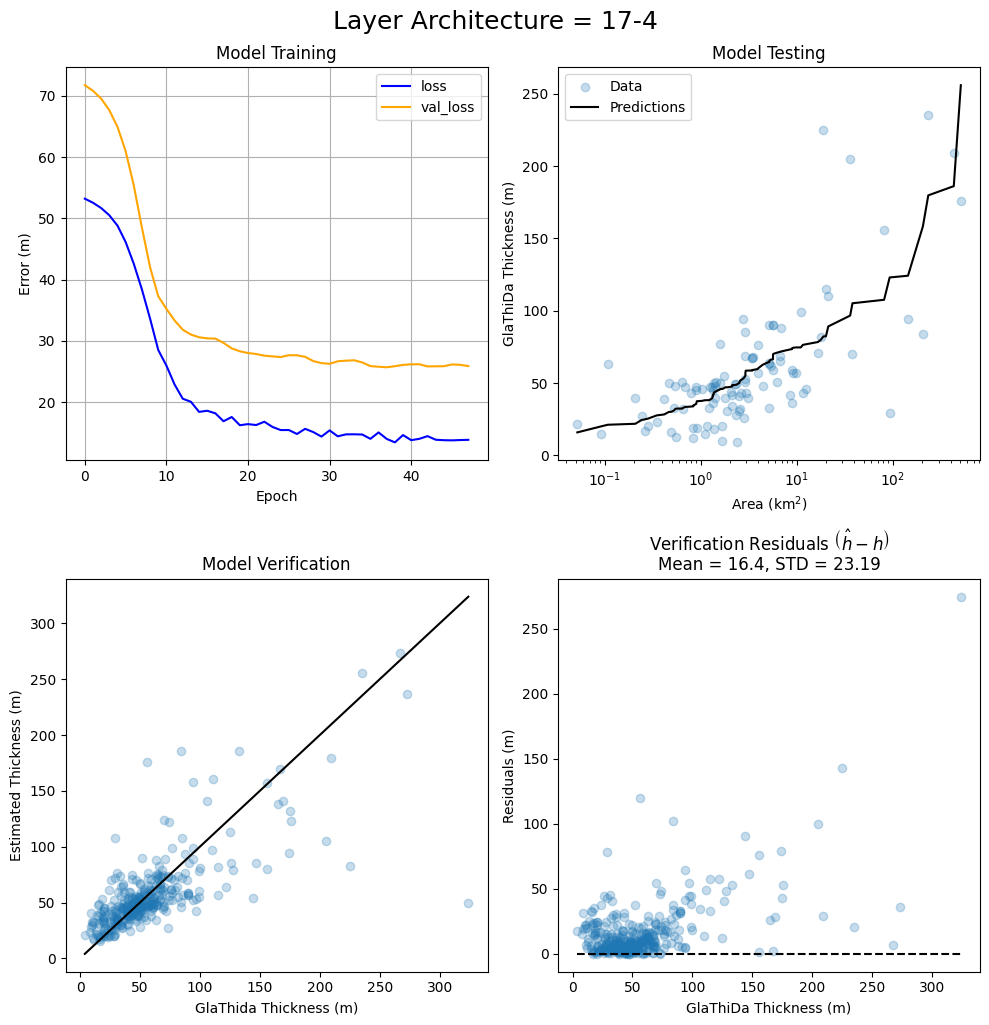

In [8]:
# m = str(
#     final_results['M'].iloc[final_results['MAE'].abs().argsort()[0]].values.flatten()[0]
# )
m = '4'
df = gl.coregister_data(m)
fig, ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].plot(
    model_history[int(m)].history['loss'], 
     label='loss',
    color = 'blue'
)
ax[0][0].plot(
    model_history[int(m)].history['val_loss'], 
    label='val_loss',
    color = 'orange'
)
#   plt.ylim([0, 10])
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Error (m)')
ax[0][0].legend()
ax[0][0].grid(True)
ax[0][0].set_title('Model Training')


ax[0][1].scatter(tefeat[int(m)]['Area'],telabs[int(m)],label = 'Data',alpha = 0.25)
ax[0][1].plot(
    tefeat[int(m)]['Area'].sort_values(
    ascending = True),np.sort(y[int(m)]),c = 'k',label = 'Predictions'
)
ax[0][1].set_xscale('log')
ax[0][1].set_title('Model Testing')
ax[0][1].set_xlabel('Area (km$^2$)')
ax[0][1].set_ylabel('GlaThiDa Thickness (m)')
ax[0][1].legend()


full_res = abs(model[n].predict(
    df.drop(['Thickness','RGIId'],axis = 1)).flatten() - df['Thickness'])
ax[1][1].scatter(df['Thickness'],full_res, label = 'Data',alpha = 0.25)
ax[1][1].plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (0,0),
    c = 'k',
    linestyle = '--'
)
ax[1][1].set_title('Residuals')
ax[1][1].set_ylabel('Residuals (m)')
ax[1][1].set_xlabel('GlaThiDa Thickness (m)')
mean = np.round(np.mean(full_res), 2)
std = np.round(np.std(full_res), 2)
ax[1][1].set_title(
    r'Verification Residuals $\left(\hat{h} - h\right)$' + '\n' +
    f'Mean = {mean}, STD = {std}'
)
#     ax[1][1].legend()
#     plt.legend()
#     plt.show()



#     y = model[k].predict(df.drop('Thickness',axis = 1)).flatten()
ax[1][0].scatter(df['Thickness'],model[n].predict(df.drop(['Thickness','RGIId'],axis = 1)),
                                              label = 'Data',alpha = 0.25)
ax[1][0].plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (df['Thickness'].min(),df['Thickness'].max()),
    'k'
)
ax[1][0].set_title('Model Verification')
ax[1][0].set_xlabel('GlaThida Thickness (m)')
ax[1][0].set_ylabel('Estimated Thickness (m)')
plt.tight_layout()
fig.suptitle(
#     'Data Parameterization = ' +  m + '\n' +
    'Layer Architecture = ' + str(l1[int(m)]) + '-' + str(l2[int(m)]),
    y = 1.02,
    fontsize = 18)


In [9]:
y = {}
for n,df in zip(range(1,5,1),df_list):
    y[n] = (model[n].predict(df.drop(['RGIId','Thickness'],axis = 1),verbose = 0).flatten())

In [10]:
w = {}
perc_res = {}
for n,df in (zip(range(1,5,1),df_list)):
    
    perc_res = (y[n] - df['Thickness']) / df['Thickness']
    mean_perc_res = np.mean(perc_res)
    mean_est = np.mean(y[n])
    
    bias = mean_perc_res * mean_est
    
    q75 = (np.percentile(perc_res, 75))
    q25 = (np.percentile(perc_res, 25))
    iqr = q75 - q25
    sig = (iqr / 1.34896) * mean_est
    w[n] = abs(bias) + sig**2

In [11]:
RGI = gl.load_RGI()
df = gl.coregister_data(m)
rfp = RGI[list(df.drop('Thickness', axis = 1))]
est = pd.DataFrame()


for n in range(1,5,1):
#     n = str(i)
    estimates = pd.Series(
        model[n].predict(rfp.drop('RGIId',axis = 1),verbose = 0).flatten(),name = str(n)
    )
    est = pd.concat([est,estimates], axis  = 1)
rfp = rfp.join(est)

In [12]:
data = gl.load_notebook_data(coregistration = '4')[['RGIId','FMT']]
data = pd.merge(rfp,data,how = 'inner', on = 'RGIId')
data = data.dropna(subset = 'FMT')

Sorting data...
Calculating point density...
Sorting data...
Calculating point density...
Sorting data...
Calculating point density...
Sorting data...
Calculating point density...


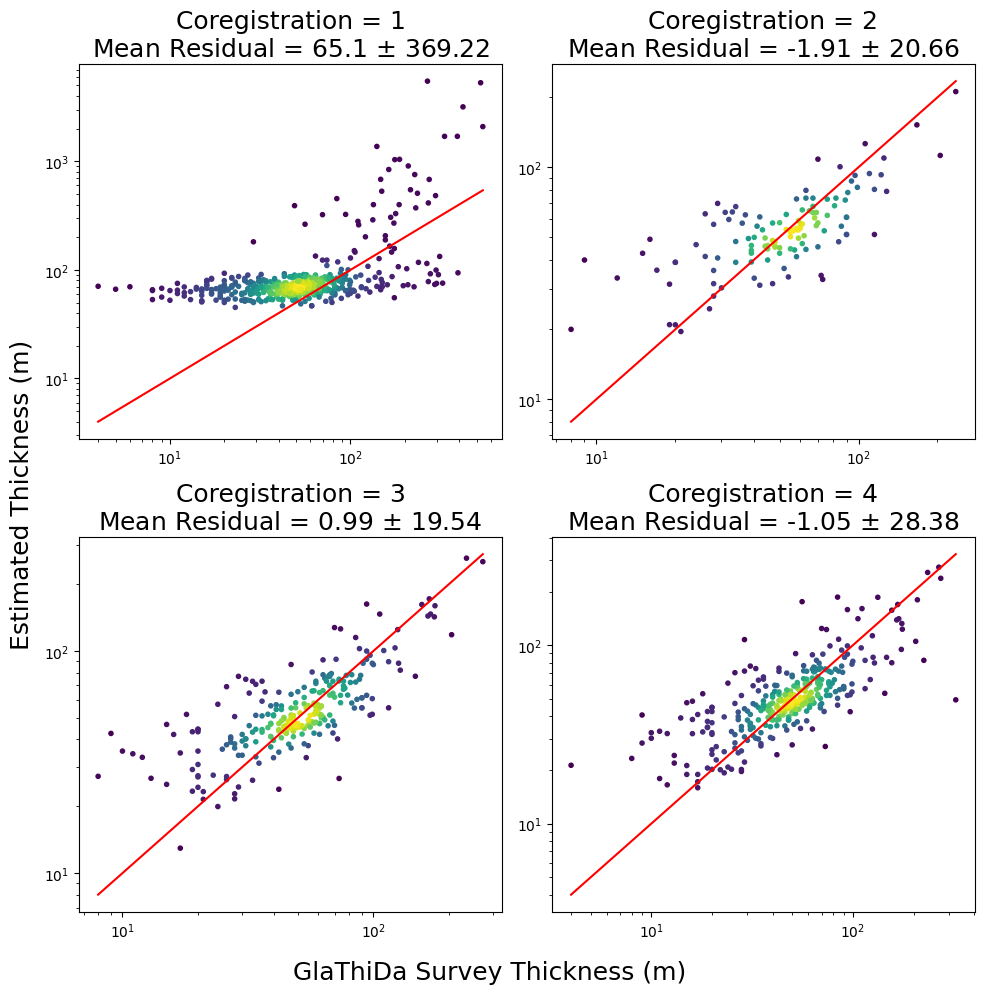

In [13]:
fig, ax = plt.subplots(2,2,figsize = (10,10))
for i, dataset in zip(range(1,5,1),[df1,df2,df3,df4]):
    c = str(i)
    df = pd.merge(dataset,rfp,how = 'inner', on = 'RGIId')
    if c == '1':
        axes = ax[0][0]
    if c == '2':
        axes = ax[0][1]
    if c == '3':
        axes = ax[1][0]
    if c == '4':
        axes = ax[1][1]
    data_1 = df[c]
    data_3 = df['Thickness']
    data_4 = df[c] - df['Thickness']
    res = np.round(np.mean(data_4),2)
    std = np.round(np.std(data_4),2)
    print('Sorting data...')
    x_1 = np.sort(data_1)
    y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)

    x_3 = np.sort(data_3)
    y_3 = 1. * np.arange(len(data_3)) / (len(data_3) - 1)

    print('Calculating point density...')
    # Calculate the point density
    xy = np.vstack([np.log10(data_1),np.log10(data_3)])

    z_1 = gaussian_kde(xy)(xy)
    axes.scatter(
            data_3,
            data_1,
            c = z_1,
            cmap = 'viridis',
            marker = '.'
        )
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.plot(
        (df['Thickness'].min(), df['Thickness'].max()),
        (df['Thickness'].min(), df['Thickness'].max()),
        color = 'red',
        linestyle = '-'
    )
    axes.set_title('Coregistration = ' + c + '\n'+
                      f'Mean Residual = {res} $\pm$ {std}',
                     fontsize = 18)
fig.supylabel('Estimated Thickness (m)', fontsize = 18)
fig.supxlabel('GlaThiDa Survey Thickness (m)', fontsize = 18)

plt.tight_layout()

In [14]:
print('Please select coregistration')
m = str(input())
# p = '4'

Please select coregistration
4


In [15]:
data_1 = (data['FMT'] / 1e3) * data['Area']
data_2 = (data[m] / 1e3) * data['Area']
x_1 = np.sort(data_1)
y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)
x_2 = np.sort(data_2)
y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

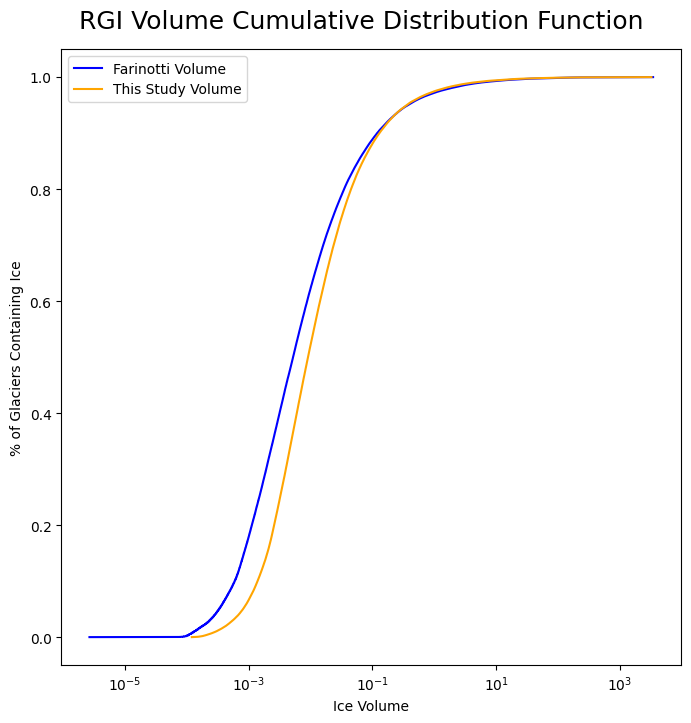

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))

plt.subplots_adjust(hspace=0.5)

plt.suptitle('RGI Volume Cumulative Distribution Function', fontsize=18, y=0.93)
fig.patch.set_facecolor('w')


plt.subplots_adjust(hspace=0.5)
plt.plot(
    x_1, 
    y_1,
    c = 'blue',
    label = 'Farinotti Volume'
    
)
plt.plot(
    x_2, 
    y_2,
    c = 'orange',
    label = 'This Study Volume'
)
plt.legend()
ax.set_xscale('log')
ax.set_xlabel('Ice Volume')
ax.set_ylabel('% of Glaciers Containing Ice')

# k = 1
# for lambd in (1/ 1e3,10/ 1e3,100/ 1e3):
#     plt.plot(x_1, 1 - np.exp(- (x_1/lambd)**k ),'--')
# plt.savefig('figs/cdf/cdf.svg')
plt.show()

In [17]:
from tqdm import tqdm
N1 = len(data_1)
assert len(data_1) == len(data_2)
resample_rate = 0.9
Nsample = int(N1 * resample_rate)
X = []
for i in tqdm(range(1000)):
    sum1 = np.sum(data_1.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])
    sum2 = np.sum(data_2.to_numpy()[np.random.choice(N1, size=Nsample, replace=False)])

    X.append (sum1-sum2)

100%|██████████| 1000/1000 [00:06<00:00, 155.66it/s]


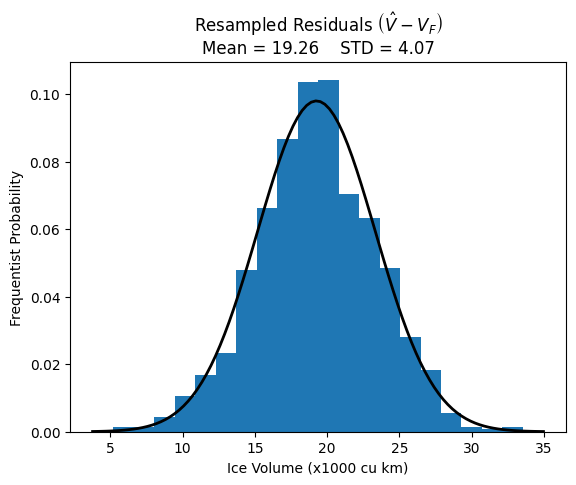

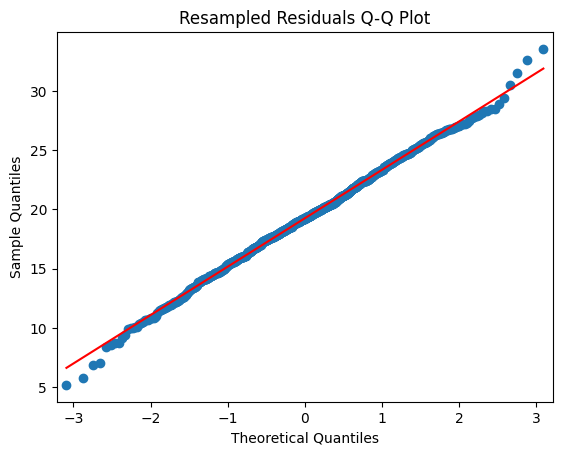

ShapiroResult(statistic=0.99842369556427, pvalue=0.5057937502861023)
KstestResult(statistic=0.9999998883823373, pvalue=0.0, statistic_location=5.178868857098989, statistic_sign=-1)


In [18]:
t = np.array(X)/resample_rate/1e3
# s = pd.Series(t)
mu, std = norm.fit(t) 
mu = np.round(mu, 2)
std = np.round(std, 2)
plt.hist(t, bins=20, density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.ylabel('Frequentist Probability')
plt.xlabel('Ice Volume (x1000 cu km)')
plt.plot(x, p, 'k', linewidth=2)

plt.title(
    f'Resampled Residuals ' + r'$\left(\hat{V} - V_{F}\right)$' +'\n' +
    f'Mean = {mu}    STD = {std}'
)
plt.show()
fig = sm.qqplot(t,line = 'r')

plt.title(f'Resampled Residuals Q-Q Plot')
plt.show()
# print(f'coregistration {m}')

print(shapiro(t))
print(kstest(t, 'norm'))

/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


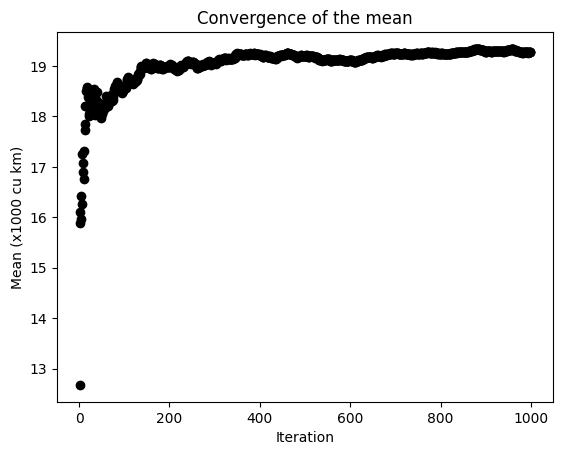

In [19]:
fig,ax=plt.subplots()
for i in range(len(X)):
    ax.plot(i,np.mean(X[0:i])/1e3/resample_rate,'ok')
plt.title('Convergence of the mean')
plt.xlabel('Iteration')
plt.ylabel('Mean (x1000 cu km)')
plt.show()

In [20]:
# mu = -mu
x = np.sort(np.array(X)/resample_rate/1e3)
sig = np.std(x)
print(f'Mean of Differences = {mu:.2f}')
print(f'Std of Differences = {sig:.2f}')
from scipy.stats import norm
value = 0 # this corresponds to zero difference
prob1=  norm.cdf(value,loc = mu, scale=sig)
prob2= norm.cdf(mu,loc = mu, scale=sig)
# print(prob1)
# print(prob2)
if prob1 > prob2:
    p2 = prob2
    p1 = prob1
    dp = 1 - (1 - prob1) - prob2
elif prob1 < prob2:
    dp = 1 - (1 - prob2) - prob1
    p2 = prob1
    p1 = prob2
print(f'Probability the mean of differences falls between {mu} and 0 = {dp}')
y = norm.cdf(x,loc = mu,scale = sig)

Mean of Differences = 19.26
Std of Differences = 4.07
Probability the mean of differences falls between 19.26 and 0 = 0.4999988894643916


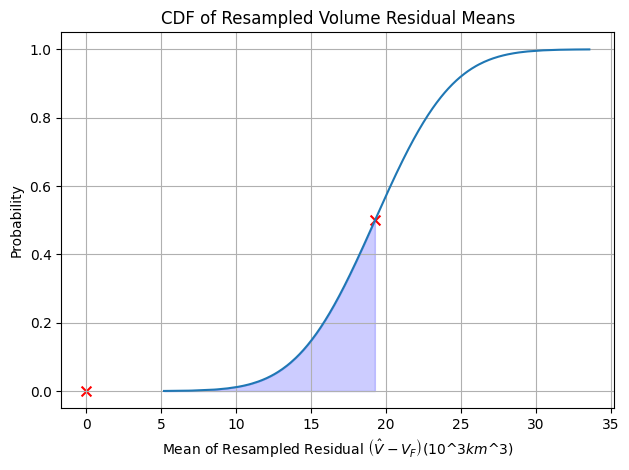

In [21]:
plt.plot(x,y)
if mu < 0:
    plt.scatter(
        0,p1,c = 'r',marker = 'x',s = 50
    )
    plt.scatter(
        mu,p2,c = 'r',marker = 'x',s = 50
    )
if mu > 0:
    plt.scatter(
        0,p2,c = 'r',marker = 'x',s = 50
    )
    plt.scatter(
        mu,p1,c = 'r',marker = 'x',s = 50
    )
plt.fill_between(
        x = x, 
        y1 = y, 
        where = (y>=p2)&(y<=p1),
        color = "b",
        alpha = 0.2)
plt.grid()
plt.title(r'CDF of Resampled Volume Residual Means')
plt.ylabel('Probability')
plt.xlabel(r'Mean of Resampled Residual $\left(\hat{V} - V_F\right) ($10^3$ km$^3$)$')
plt.tight_layout()

In [22]:
from scipy import stats

In [23]:
print(data_1.var())
print(data_2.var())

376.17243985271244
355.73903700544827


In [24]:
stats.ttest_ind(data_1, data_2, equal_var=True)

Ttest_indResult(statistic=1.5244115369112679, pvalue=0.12740667358857682)

In [25]:
vol = data[m] / 1e3 * data['Area']
sum_vol = sum(vol)
print(sum_vol / 1e3)

130.32125255756193
